In [179]:
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from autometric.utils import *

## Progress bar
from tqdm.auto import tqdm, trange

import torch
import sys

sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pullback Comparisons with the Affinity Matching AE
> Witty encapsulation

The encoder pullback depends entirely on the fidelity of the embedding. Theory (in Neural Fischer Information Metric) suggests that if the encoder is trained to match the square-root JS divergences between diffusion probabilities in the input, then the encoder pullback is the Fischer Information Metric. However this is true only if the euclidean metric being pulled back from embedding space *exactly matches* the JSD metric – i.e. produces identical distances.

Hence, while the decoder pullback metric can, in theory, be perfect - and depends only on the aptitude of the decoder and vagaries of training - the encoder pullback metric seems *a priori* limited by the geometry of the manifold.

This gives rise to our hypothesis:

**Hypothesis**: Euclidean encoder pullback metrics fail to recover the true metric in proportion with the curvature

**Prediction**: Various means of metric comparison (e.g. MSE between matrices, dot product between eigenvectors, predicted geodesic distances, unit lengths) will be better preserved for flat manifolds, and worsely preserved in line with the degree of curvature.

**Falsification**: If there is no effect as described above, or even worse, an inverse effect, we can assign low probability to this hypothesis.

**Confounding Factors**: The fidelity of encoder pullbacks is also related to the quality of training. It might be that more highly curved surfaces are simply harder to embed, which could give positive results but for a different reason. A control here can be provided by the decoder pullback, which should diminish in line with the quality of the embedding, but not with the curvature.

## Experimental Setup:

We'll use hemispheres and saddles of increasing intensities of curvature. These will be embedded with a trained Affinity Matching AE. Then we'll apply metric-matching criteria in `criteria` to the results.

# Machinery

Create the datasets

In [217]:
from autometric.datasets import Hemisphere, Saddle
def create_datasets(
    num_saddles = 5,
    num_spheres = 5,
    max_sphere_radius = 5,
    max_saddle_intensity = 10,
    num_points_per_dataset = 2000,
):
    saddle_intensities = np.linspace(0.001, max_saddle_intensity, num_saddles)[::-1]
    saddles = [Saddle(num_points = num_points_per_dataset, a = i, b = i) for i in saddle_intensities]
    sphere_radii = 1/np.linspace(1/max_sphere_radius, max_sphere_radius,num_spheres)
    spheres = [Hemisphere(num_points = num_points_per_dataset, r = i) for i in sphere_radii]
    return saddles + spheres

In [218]:
n = 10
ss = create_datasets(num_saddles = n, num_spheres = n,
                     max_saddle_intensity=1,
                     num_points_per_dataset=2000
                     )

In [219]:
curvatures = [float(torch.mean(m.ks)) for m in ss]

In [220]:
curvatures

[-1.286532998085022,
 -1.254775881767273,
 -1.1867271661758423,
 -1.0853909254074097,
 -0.9592145681381226,
 -0.7821527123451233,
 -0.5668392181396484,
 -0.3146975040435791,
 -0.0939980149269104,
 -7.999957233550958e-06,
 0.08000000566244125,
 1.075555682182312,
 3.2088890075683594,
 6.479999542236328,
 10.888888359069824,
 16.43556022644043,
 23.119997024536133,
 30.94222640991211,
 39.9022216796875,
 49.99998474121094]

Train models on each of these.

Set up model

In [221]:
from models.affinity_matching import AffinityMatching

In [222]:
model_hypers = {
    'ambient_dimension': 3,
    'latent_dimension': 2,
    'model_type': 'affinity',
    'loss_type': 'kl',
    'activation': 'relu',
    'layer_widths': [256, 128, 64],
    'kernel_method': 'gaussian',
    'kernel_alpha': 1,
    'kernel_bandwidth': 1,
    'knn': 5,
    't': 0,
    'n_landmark': 5000,
    'verbose': False
}
training_hypers = {
    'data_name': 'randomtest',
    'max_epochs': 100,
    'batch_size': 64,
    'lr': 1e-3,
    'shuffle': True,
    'weight_decay': 1e-5,
    'monitor': 'val_loss',
    'patience': 100,
    'seed': 2024,
    'log_every_n_steps': 100,
    'accelerator': 'auto',
    'train_from_scratch': True,
    'model_save_path': './affinity_matching'
}

Fit on data

In [223]:
trained_models = []
for D in tqdm(ss):
    X = D.X.numpy()
    # Test AffinityMatching model
    model = AffinityMatching(**model_hypers)
    model.fit(
        X,
        train_mask=None, 
        percent_test=0.3, 
        **training_hypers)

    Z = model.encode(torch.tensor(X, dtype=torch.float))
    X_hat = model.decode(Z)
    trained_models.append(model)

  0%|          | 0/20 [00:00<?, ?it/s]

Running PHATE on 979 observations and 3 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Calculating optimal t...


  Automatically selected t = 22
Calculated optimal t in 0.11 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.03 seconds.
Calculating metric MDS...
Calculated metric MDS in 0.35 seconds.
row_stochastic_matrix torch.Size([979, 979])
checking row sum: False
row sum:  tensor([1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001,
        1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001,
        1.0001, 1.0001])
Calculating optimal t...
  Automatically selected t = 22
Calculated optimal t in 0.11 seconds.
Running PHATE on 1400 observations and 3 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Calculated graph and diffusion operator in 0.01 seconds.
Calculating optimal t...
  Automatically selected t = 23
Calculated optimal t in 0.24 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.09 seconds.
Calculating metric MDS...
Calculated

# Results

In [224]:
from autometric.criteria import *

In [230]:
from collections import defaultdict
scores = defaultdict(list)
for i in trange(len(ss)):
    model = trained_models[i]
    manifold = ss[i]
    # Some metrics don't like cuda
    device = torch.device('cpu')
    model.device = device
    model.encoder = model.encoder.to(device)
    model.decoder = model.decoder.to(device)
    ## COMPUTE METRICS
    # Metric MSE
    scores['metric mse'].append(
        metric_mse_criterion(model, model.whole_dataloader, manifold, pullback_type="encoder").detach()
        )
    # evec alignment
    score, alignments = metric_evec_alignment(model, model.whole_dataloader, manifold, pullback_type="encoder", intrinsic_dimension=2)
    scores['metric eigenvector alignment'].append(
        score
    )
    scores['metric eigenvector alignment pointwise'].append(alignments)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'Cosine similarity')

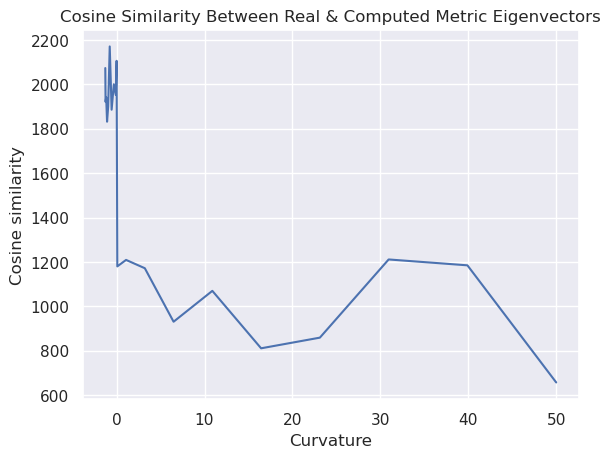

In [228]:
plt.plot(curvatures,scores['metric eigenvector alignment'])
plt.title("Cosine Similarity Between Real & Computed Metric Eigenvectors")
plt.xlabel("Curvature")
plt.ylabel("Cosine similarity")

Text(0, 0.5, 'MSE')

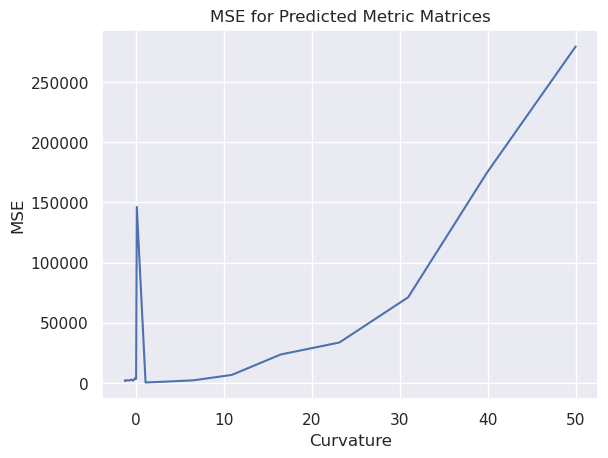

In [229]:
plt.plot(curvatures,scores['metric mse'])
plt.title("MSE for Predicted Metric Matrices")
plt.xlabel("Curvature")
plt.ylabel("MSE")

Plot Models

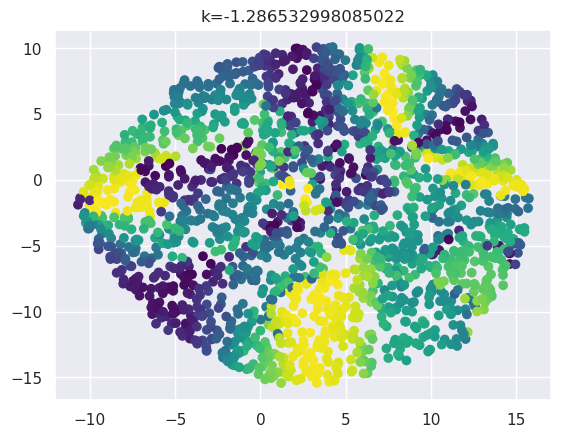

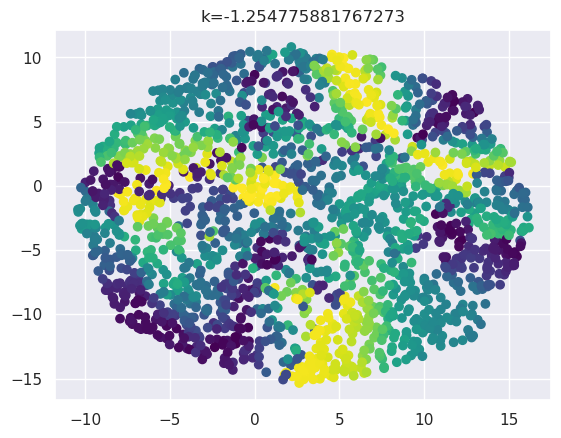

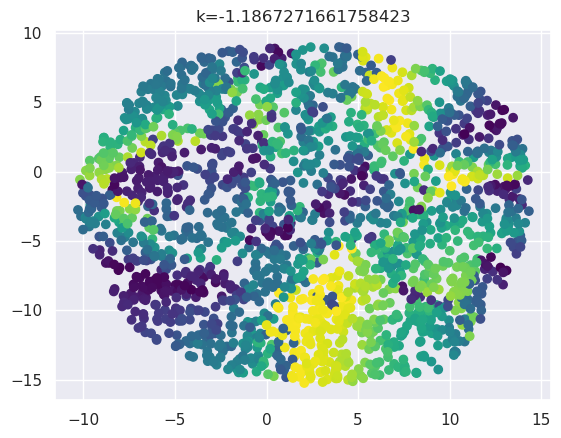

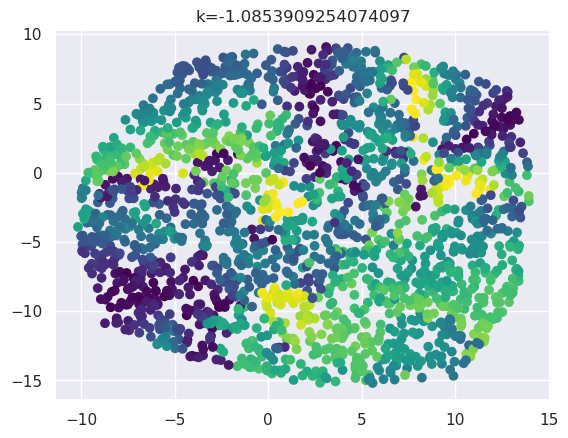

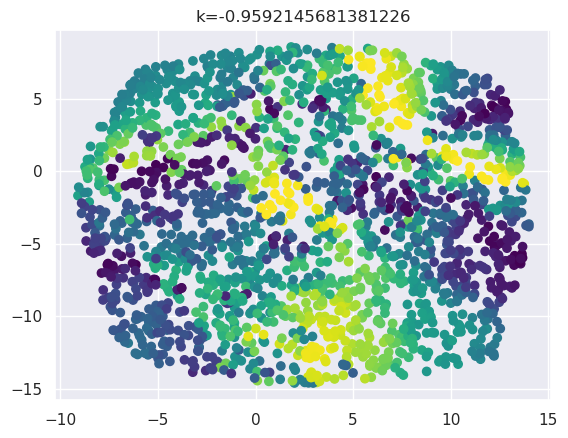

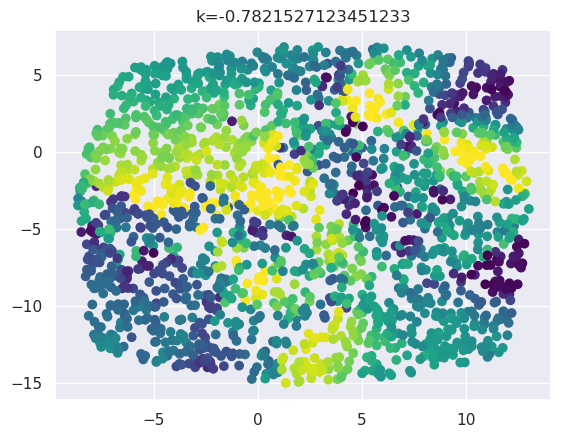

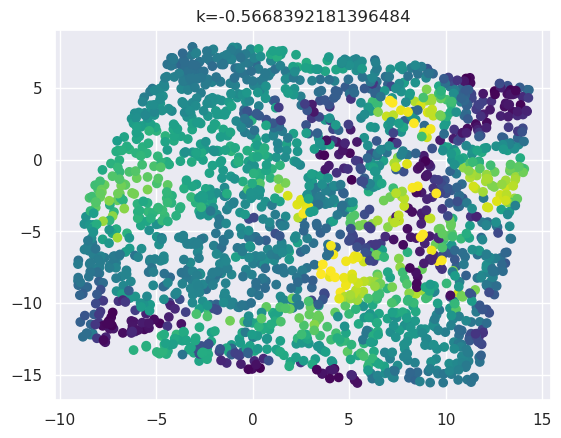

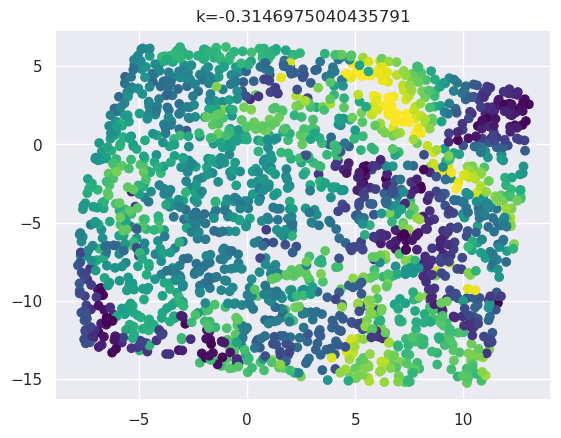

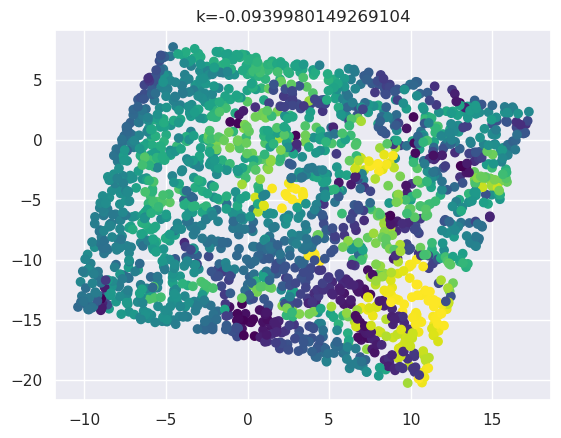

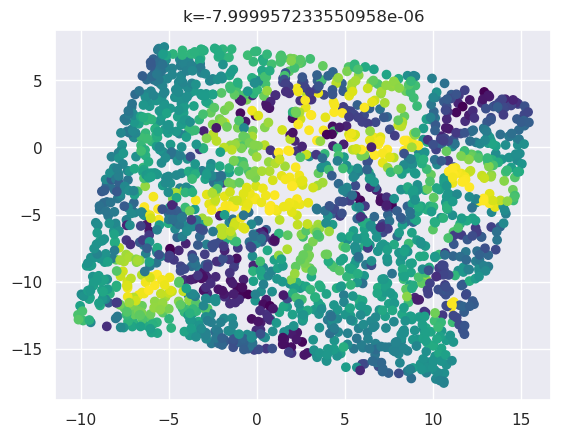

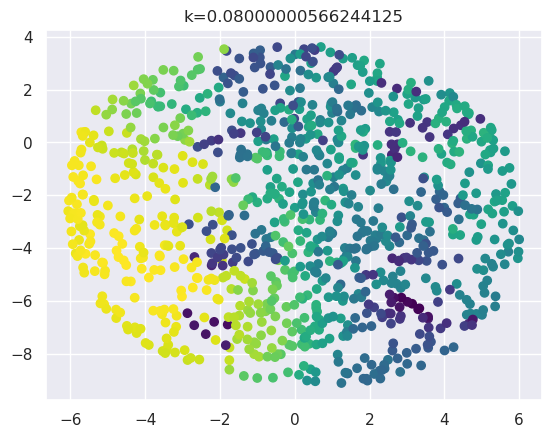

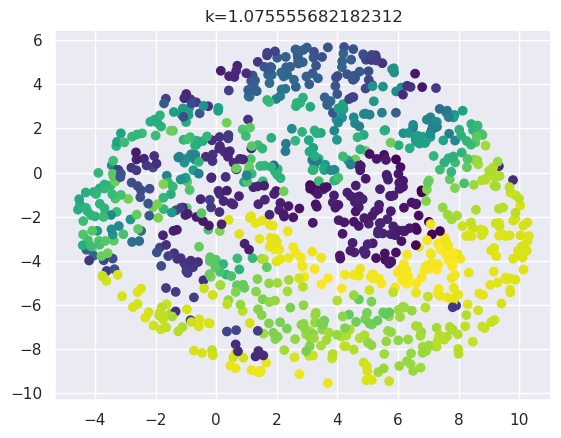

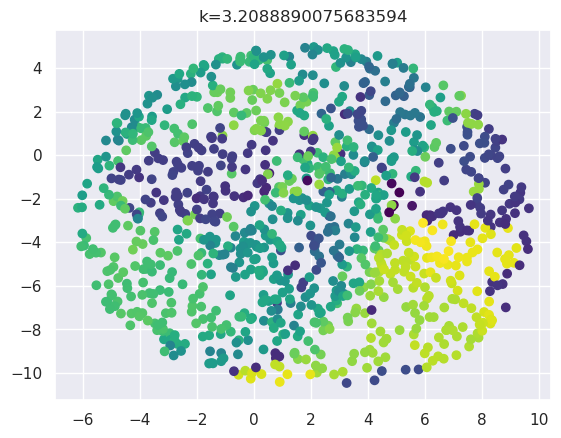

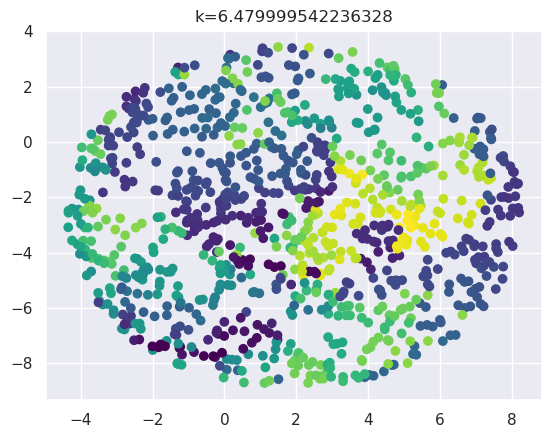

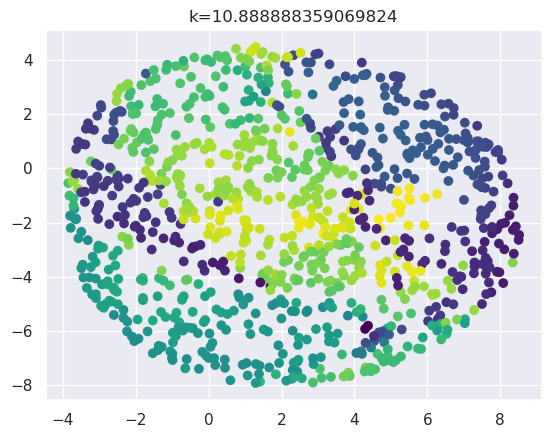

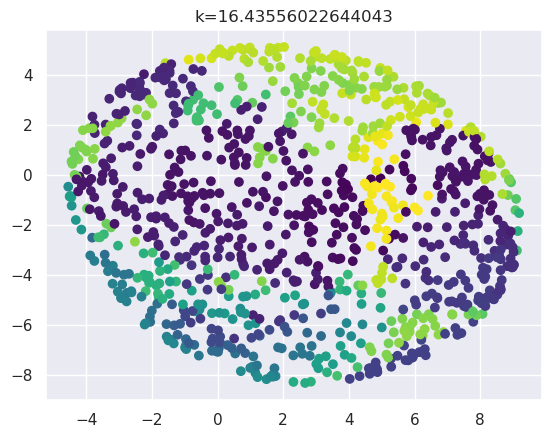

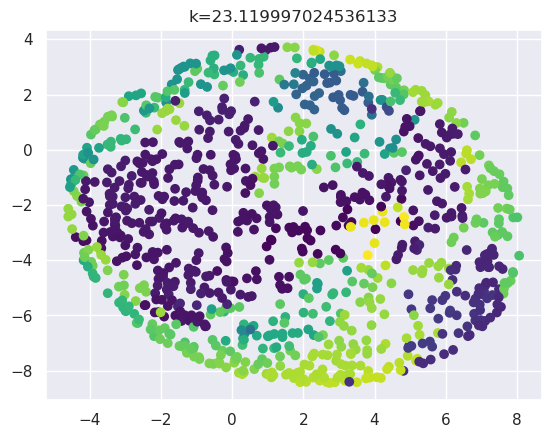

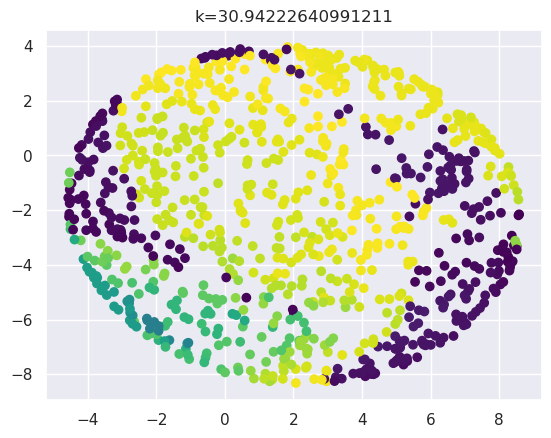

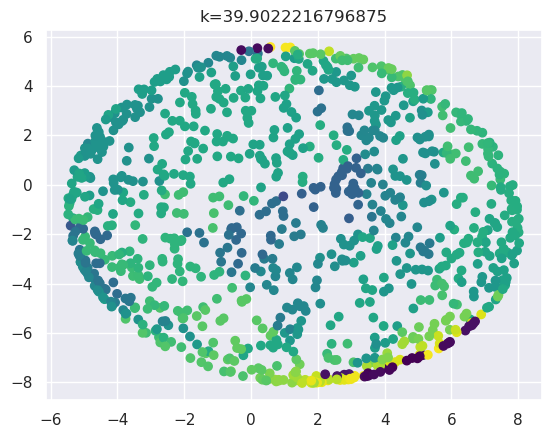

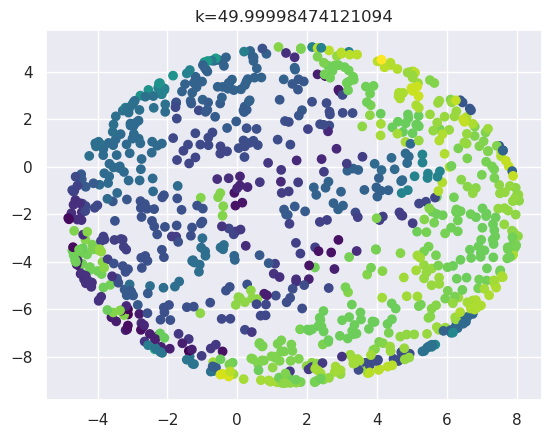

In [236]:
plots = [visualize_embedding(trained_models[i], trained_models[i].whole_dataloader, scores['metric eigenvector alignment pointwise'][i], title = f"k={curvatures[i]}") for i in range(len(ss))]

In [251]:
import matplotlib.pyplot as plt

def plot_in_grid(plot_funcs, nrows, ncols, figsize=(10, 10)):
    """
    Plots using a list of plotting functions in a grid.

    Parameters:
    - plot_funcs: list of plotting functions, each accepting a plt.Axes object
    - nrows: number of rows in the grid
    - ncols: number of columns in the grid
    - figsize: tuple indicating figure size
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case of multiple rows and columns

    for plot_func, ax in zip(plot_funcs, axes):
        plot_func(ax)  # Call each plotting function with its corresponding Axes

    plt.tight_layout()
    plt.show()


NotImplementedError: cannot remove artist

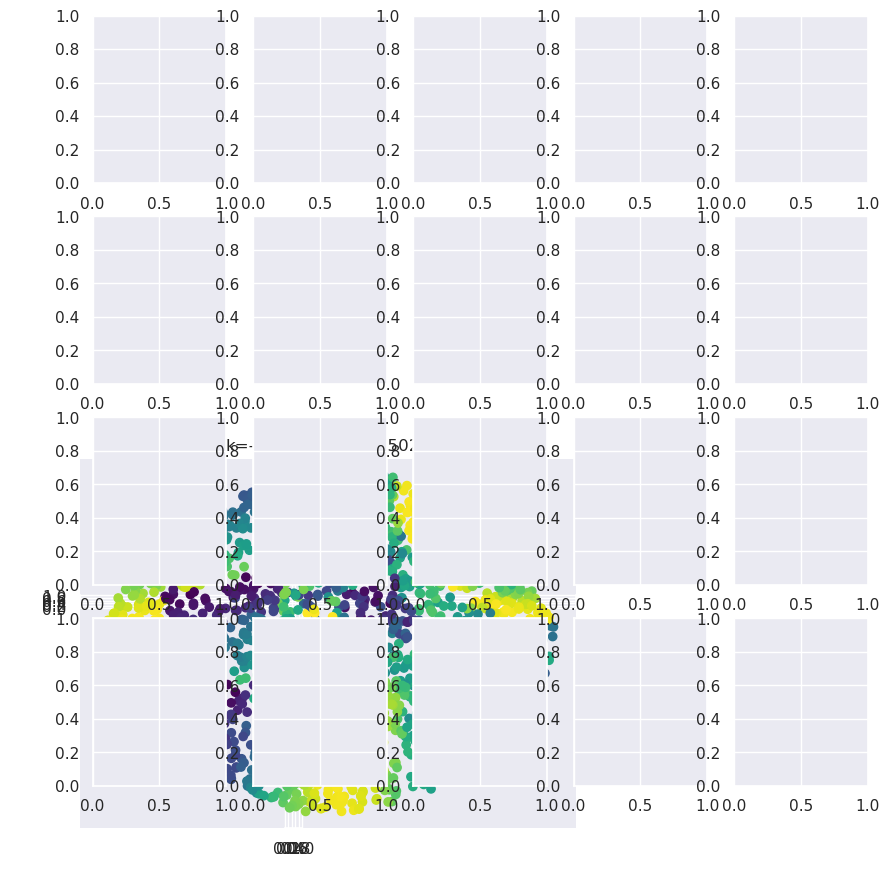

In [252]:
plot_axes_in_grid(plots, 4,5)

In [15]:
device = torch.device('cpu')
model.device = device
model.encoder = model.encoder.to(device)
model.decoder = model.decoder.to(device)

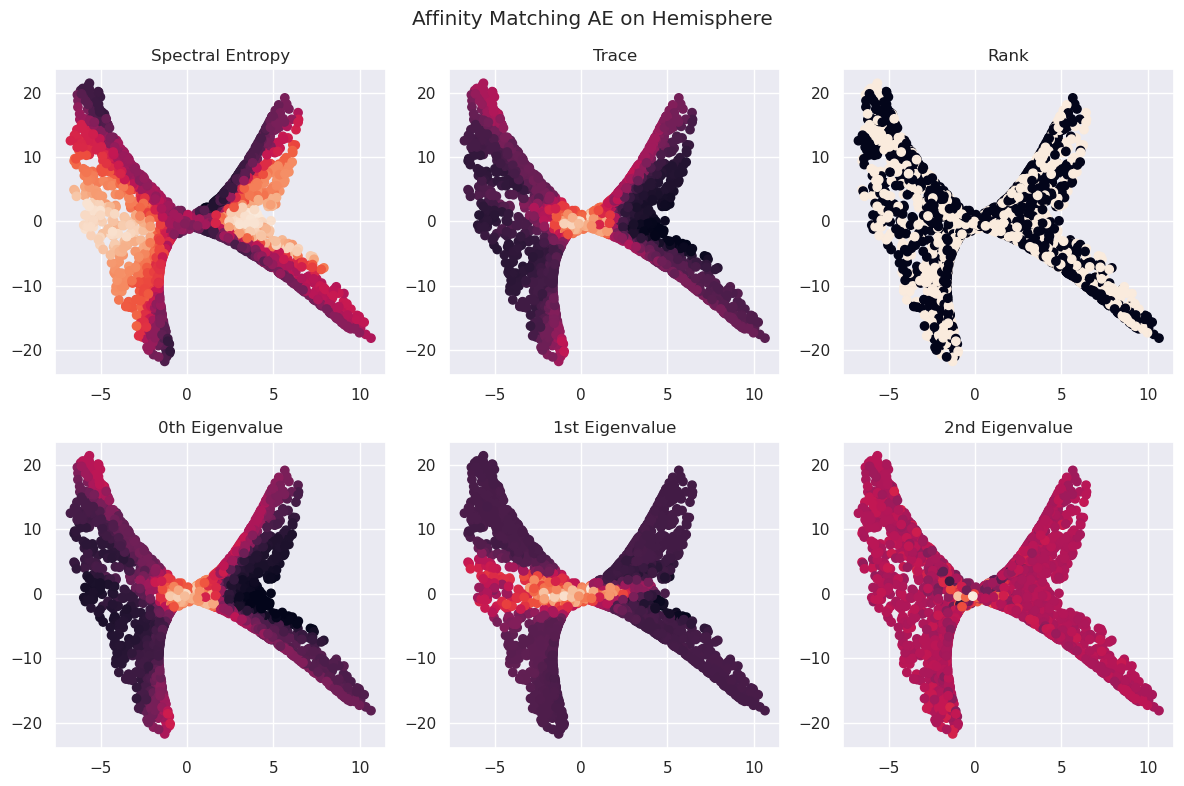

In [16]:
visualize_encoder_pullback_metrics(model, model.whole_dataloader, "Affinity Matching AE on Hemisphere")

In [59]:
mse, computed_curvatures = curvature_matching_metric(
    model, model.whole_dataloader, manifold.ks[:len(manifold.X)], 
    pullback_type = "encoder",
)
mse

/home/piriac/Pumberton/Workshop/23-Geometric-AE/dmae/src/autometric/src/autometric/criteria.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sc = rm.scalar_curvature(base_point = torch.tensor(input_points[i])).detach().cpu()


Finished scalar curvature computation with 15 singular points given NaN values.


tensor(3.4607e-05)

In [64]:
metric_mse_criterion(model, model.whole_dataloader, manifold, pullback_type="encoder")

tensor(10118174.7590, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [69]:
np.argsort([1,4,2,5])

array([0, 2, 1, 3])

In [79]:
score, alignments = metric_evec_alignment(model, model.whole_dataloader, manifold, pullback_type="encoder", intrinsic_dimension=2)

In [80]:
score

979.019086034449

In [51]:
from autometric.geometry import *
pbm = PullbackMetric(3, model.encoder.encode)
lcc = LeviCivitaConnection(3, pbm)
rm = RiemannianManifold(3, (1, 1), metric=pbm, connection=lcc)

In [62]:
np.argsort([0,1,2,3,8,5])

array([0, 1, 2, 3, 5, 4])

In [61]:
manifold.metric.metric_matrix(pointcloud)

tensor([[[ 1961.3361, -3354.7222,     0.0000],
         [-3354.7222,  5753.7336,     0.0000],
         [    0.0000,     0.0000,     0.0000]],

        [[ 1037.2717, -2264.2659,     0.0000],
         [-2264.2659,  4965.8119,     0.0000],
         [    0.0000,     0.0000,     0.0000]],

        [[ 6650.2139, -4272.9258,     0.0000],
         [-4272.9258,  2751.1122,     0.0000],
         [    0.0000,     0.0000,     0.0000]],

        ...,

        [[ 8447.0520, -9615.7857,     0.0000],
         [-9615.7857, 10955.4112,     0.0000],
         [    0.0000,     0.0000,     0.0000]],

        [[   99.7952,  -164.2597,     0.0000],
         [ -164.2597,   285.6556,     0.0000],
         [    0.0000,     0.0000,     0.0000]],

        [[ 7094.1733, -2950.8626,     0.0000],
         [-2950.8626,  1232.1209,     0.0000],
         [    0.0000,     0.0000,     0.0000]]], dtype=torch.float64)

In [40]:
lcc.christoffels(pointcloud[1])

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not list

# Decoder

Indicatrices

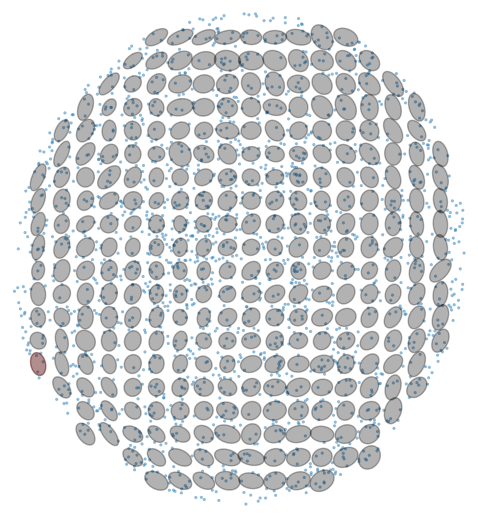

In [90]:
plot_indicatrices(
    model, model.whole_dataloader
)

In [1]:
curvature_matching_metric(
    model, model.whole_dataloader, hemisphere.ks[:len(hemisphere.X)], pullback_type = "decoder",
)

NameError: name 'curvature_matching_metric' is not defined

# Conclusion